#Load data

In [0]:
import zipfile
import os
with zipfile.ZipFile('NMNISTsmall.zip') as zip_file:
    for member in zip_file.namelist():
        if not os.path.exists('./' + member):
            zip_file.extract(member, './')

In [2]:
import numpy as np
import spikeFileIO as io
from matplotlib import pyplot as plt
import os

from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:

#lets collect addresses of training and test data
def load(fname):
    ''' Load the file using std open'''
    f = open(fname,'r')

    data = []
    for line in f.readlines():
        data.append(line.replace('\n','').split(' '))

    f.close()

    return data

path = 'NMNISTsmall/'
#train data
training_files = load('NMNISTsmall/train1K.txt')
training_files = training_files[1:]

training_addrs = []
training_labels = []
for i in range (len(training_files)):
  training_addrs.append(path+training_files[i][0][:-2]+'.bs2')
  training_labels.append(training_files[i][0][-1])

#test data
test_files = load('NMNISTsmall/test100.txt')
test_files = test_files[1:]

test_addrs = []
test_labels = []
for i in range (len(test_files)):
  test_addrs.append(path+test_files[i][0][:-2]+'.bs2')
  test_labels.append(test_files[i][0][-1])

Data representation review:

In the original paper, the spiking MNIST set is made according to the raw pixel brightness values. All spiking time is in a range from 0 to 1. They code dark pixels eariler than brighter ones. Those pixels not spiking are recognised as not-spiking-neurons which is dealt specifically in the training process.

Now the problem becomes that how can we construct the data structure of NMNIST, and still do the work.

The first difference between the Google devised data and our data is that their input neuron can have 1 or 0 spike at a specific pixel, wheras our data can have multiple spikes in one pixel. Take the 0th sample as an example, it has 4681 spikes, while 4197 of pixels spike more than once.


Now my decision is to only retain the first spiking time of each pixel following the logic of the original paper: they only retain the first spike in the hidden units. We will see what we get. 

In [0]:
def xyp21dim_onlyfirstspikepreserved(TD):
  TD_temporal = torch.ones((34,34,2))*2.8 #assumed that 2.8 is a mask number, identified as no-spiking time. 2.8 is due to historical reason
  for i in range(TD.x.shape[0]):
    if TD_temporal[TD.x[i], TD.y[i], TD.p[i]] == 2.8:
      TD_temporal[TD.x[i], TD.y[i], TD.p[i]] = TD.t[i]/150 #normalisation; taking 150 as the expected largest time 
  return TD_temporal

In [0]:
def dense_data_generator(X, y, batch_size, shuffle=True, device = 'cuda', dtype=torch.float):
    """ This generator takes training data's address and generates spiking network input as dense tensors. 

    Args:
        X: The data ( 'data/userx_lighting_conditions/y.npy' )
        y: The labels
        batch_size: batch size
    """ 
    labels_ = np.array(y,dtype=np.int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))

    if shuffle:
        np.random.shuffle(sample_index)

    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = torch.empty((batch_size,2*34*34),dtype=dtype)
        for bc,i in enumerate(batch_index):
            TD = io.read2Dspikes(X[i])
            X_batch_temp = xyp21dim_onlyfirstspikepreserved(TD)
            #flatten dimensions and save in X_batch
            X_batch[bc] = X_batch_temp.view((-1))
        y_batch = torch.tensor(labels_[batch_index],device=device)
        yield [X_batch.to(device=device), y_batch.to(device=device)] 
        counter+=1    

# Kernel

Kernel generates spiking time of a neuron given some input spike time 

In [0]:
def alpha_kernel_response_temporal_v2(input_time, weights, tau = 1, thre = 1, t_max = 300): #faster implementation
  #argument: input_time shape = (n_batch x n_input);  weights shape = (n_input x n_output)
  #alpha_kernel_response is t*e^(tau*t); the increment of this kernel is (1+t*tau)*exp(tau*t)
  n_batch = input_time.shape[0]
  n_input = input_time.shape[1]
  n_output = weights.shape[1]
  precision = 100.0

  v_accu = torch.zeros((n_batch, n_output), device = input_time.device)
  spike_time = torch.zeros_like(v_accu)
  spike_time_mem = torch.ones_like(v_accu)
  for t in range(t_max):
    t_clamp = torch.clamp(t/precision -input_time, 0, t_max)
    invalid_incr = (t_clamp==0)
    v_incr = torch.exp(-tau*t_clamp)*(1-tau*t_clamp) #unweighted dv/dt
    v_incr[invalid_incr] = 0
    v_incr = torch.mm(v_incr, weights)/precision #dv/dt * delta_t
    v_accu += v_incr #update the membrane potential at time instance t
    index = (v_accu>thre) & (spike_time_mem == 1) #output index to update the earilest spiking time
    spike_time[index] = t/precision
    spike_time_mem[index] = 0 #mark the updated output index such that it will not be updated again
  
  index_nospike = (spike_time == 0)
  spike_time[index_nospike] = 2.8 #an arbirary number that identifies no-spiking neuron
  
  return spike_time.to(input_time.device)

# Network Configuratoin

Here we configure a SNN with input layer of a size 2x34x34, a hidden layer of a size 100, and an output layer of a size 10. Moreover, both the input layer and the hidden layer have one bias to prevent neuron from not spiking.

In [7]:
nb_inputs  = 2*34*34
nb_hidden  = 100
nb_outputs = 10
#we assume there is only 1 batch now

#weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

dtype=torch.float
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

#initialisation
weight_scale = np.sqrt(2)

nb_bias1 = 1
nb_bias2 = 1


w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=7.83912*weight_scale/np.sqrt(nb_inputs+nb_hidden+nb_bias1), std=weight_scale/np.sqrt(nb_inputs+nb_hidden+nb_bias1)) #the mean is brought up to 1.5 to force neurons to spike initially

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=7.83912*weight_scale/np.sqrt(nb_inputs+nb_hidden+nb_bias2), std=weight_scale/np.sqrt(nb_hidden+nb_outputs+nb_bias2))

bias1_time = torch.empty((nb_bias1),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(bias1_time, a=0.0, b=1.0)
bias1_weight = torch.empty((nb_bias1, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(bias1_weight, mean=-0.275419*weight_scale/np.sqrt(nb_inputs+nb_bias1+nb_hidden), std=weight_scale/np.sqrt(nb_inputs+nb_bias1+nb_hidden))
#torch.nn.init.uniform_(bias1_weight, a=1.0, b=1.0)


bias2_time = torch.empty((nb_bias2),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(bias2_time, a=0.0, b=1.0)
bias2_weight = torch.empty((nb_bias2, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(bias2_weight, mean=-0.275419*weight_scale/np.sqrt(nb_outputs+nb_bias2+nb_hidden), std=weight_scale/np.sqrt(nb_outputs+nb_bias2+nb_hidden))
#torch.nn.init.uniform_(bias2_weight, a=1.0, b=1.0)



tensor([[-0.0367,  0.0213, -0.1721,  0.0224, -0.1343, -0.1208,  0.0648,  0.1651,
         -0.1455, -0.1769]], device='cuda:0', requires_grad=True)

In [8]:
print(bias1_time.shape)
print(w1.shape)

torch.Size([1])
torch.Size([2312, 100])


# Helper functions

helper function that solves W-Lambert function

In [0]:
#https://github.com/google/ihmehimmeli/blob/master/tempcoding/lambertw.cc
def LambertW0InitialGuess_vec(x):
  kNearBranchCutoff = -0.3235
  kE = 2.718281828459045
  x_copy = x.clone()

  # Sqrt approximation near branch cutoff.
  index1 = (x < kNearBranchCutoff)
  x_copy[index1] = -1.0+torch.sqrt(2.0*(1+kE*x[index1]))

  # Taylor series between [-1/e and 1/e].
  index2 = (x > kNearBranchCutoff) & (x < -kNearBranchCutoff)
  x_copy[index2] = x[index2] * (1 + x[index2] * (-1 + x[index2] * (3.0 / 2.0 - 8.0 / 3.0 * x[index2])))

  #Series of piecewise linear approximation
  index3 = (x > -kNearBranchCutoff) & (x < 0.6)
  x_copy[index3] =  0.23675531078855933 + (x[index3] - 0.3) * 0.5493610866617109
  
  index4 = (x > 0.6) & (x < 0.8999999999999999)
  x_copy[index4] = 0.4015636367870726 + (x[index4] - 0.6) * 0.4275644294878729

  index5 = (x > 0.8999999999999999) & (x < 1.2)
  x_copy[index5] = 0.5298329656334344 + (x[index5] - 0.8999999999999999) * 0.3524368357714513

  index6 = (x > 1.2) & (x < 1.5)
  x_copy[index6] = 0.6355640163648698 + (x[index6] - 1.2) * 0.30099113800452154

  index7 = (x > 1.5) & (x < 1.8)
  x_copy[index7] = 0.7258613577662263 + (x[index7] - 1.5) * 0.2633490154764343
  
  index8 = (x > 1.8) & (x < 2.0999999999999996)
  x_copy[index8] = 0.8048660624091566 + (x[index8] - 1.8) * 0.2345089875713013;
  
  index9 = (x > 2.0999999999999996) & (x < 2.4)
  x_copy[index9] =  0.8752187586805469 + (x[index9] - 2.0999999999999996) * 0.2116494532726034

  index10 = (x > 2.4) & (x < 2.6999999999999997)
  x_copy[index10] = 0.938713594662328 + (x[index10] - 2.4) * 0.19305046534383152

  index11 = (x > 2.6999999999999997) & (x < 2.9999999999999996)
  x_copy[index11] = 0.9966287342654774 + (x[index11] - 2.6999999999999997) * 0.17760053566187495
  
  #asymptotic approxiamtion
  index12 = ~(index1 + index2 + index3 + index4 + index5 + index6 +index7 +index8 +index9 +index10 + index11)
  l = torch.log(x[index12])
  ll = torch.log(l)
  x_copy[index12] = l - ll + ll/l
  return x_copy

def LambertW0_vec(x):
  x_copy = x.clone()
  kReciprocalE = 0.36787944117
  kDesiredAbsoluteDifference = 1e-3
  kNumMaxIters = 10

  index1 =  (x < -kReciprocalE)
  x_copy[index1] = 0
  #return x, False

  index2 = (x == 0.0)
  x_copy[index2] = 0

  index3 = (x == -kReciprocalE)
  x_copy[index3] = -1 

  index4 = ~(index1 + index2 + index3)

  #current guess
  w_n = LambertW0InitialGuess_vec(x[index4])
  have_convergence = False

  #fritsch iteration
  for i in range(1):
    z_n = torch.log(x[index4] / w_n) - w_n
    q_n = 2.0 * (1.0 + w_n) * (1.0 + w_n + 2.0 / 3.0 * z_n)
    e_n = (z_n / (1.0 + w_n)) * ((q_n - z_n) / (q_n - 2.0 * z_n))
    w_n = w_n * (1.0 + e_n)
    #Done this way as the log is the expensive part above.
    #if (torch.abs(z_n) < kDesiredAbsoluteDifference):

  x_copy[index4] = w_n
  return x_copy
    


# Forward and backward propagation

In [0]:
class SNN_process_v3(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, input, weight, bias_time, bias_weight):
        """
        Argument: input is input spike time of dimension (n_output)
                  weight is of dimension (n_input, n_output)
                  bias_time is of dimension (n_bias)
                  bias_weight is of dimension (n_bias, n_output)
        """
        #####firstly, we combine the bias and inputs, and their weights#####
        batch_size = input.shape[0]
        n_bias = bias_time.shape[0]
        bias_time_broadcasted = bias_time.view(1,n_bias).repeat(batch_size,1)
        x_n_bias = torch.cat((input, bias_time_broadcasted),-1)

        w_n_bias = torch.cat((weight,bias_weight),0)

        #####membrane dynamics begin here###################################
        max_time_units = 900
        tau = 2 #0.181769
        theta = 0.5 #1.16732
        not_spike_time = 2.8 #if the neuron does not spike, the spike time is assigned to 2.8 sec. It is a potential problem
        nb_outputs = w_n_bias.shape[1]

        spk = alpha_kernel_response_temporal_v2(x_n_bias, w_n_bias, tau = tau, thre = theta, t_max = max_time_units)
        ctx.intermediate_results = x_n_bias, w_n_bias, spk, n_bias

        return spk

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        x_n_bias, w1_n_bias, spk, n_bias = ctx.intermediate_results
        tau = 2 #0.181769
        theta = 0.5 #1.16732
        input = x_n_bias
        batch_size = x_n_bias.shape[0]
        nb_inputs = w1_n_bias.shape[0]
        nb_outputs = w1_n_bias.shape[1]

        #t0 = time.time()
        #compute ingredients of gradients 
        AI = torch.zeros_like(spk).to(input.device)  #initialisation
        BI = torch.zeros_like(spk).to(input.device)
        t_out = torch.zeros_like(spk).to(input.device)
        WI = torch.zeros_like(spk).to(input.device)
        grad_input = torch.zeros((batch_size, nb_inputs, nb_outputs)).to(input.device)
        grad_weight = torch.zeros((batch_size, nb_inputs, nb_outputs)).to(input.device)

        #extend matrices to a common shape
        x_n_bias_modified = x_n_bias.unsqueeze(2).repeat(1,1,nb_outputs)
        grad_output_modified = grad_output.unsqueeze(1).repeat(1,nb_inputs,1)
        w1_n_bias_repeated = w1_n_bias.unsqueeze(0).repeat(batch_size,1,1)

        #find the index for valid inputs 
        spk_modified = spk.unsqueeze(1).repeat(1,nb_inputs,1)
        valid_index = x_n_bias_modified < spk_modified

        #print(valid_index)
        AI = torch.sum(torch.exp(x_n_bias_modified*tau)*w1_n_bias_repeated*valid_index, 1).to(x_n_bias.device)
        BI = torch.sum(torch.exp(x_n_bias_modified*tau)*x_n_bias_modified*w1_n_bias_repeated*valid_index, 1).to(x_n_bias.device)
        #t1 = time.time()
        #print('AI and BI', t1-t0)
        exploding_WI_idx_batch = []
        exploding_WI_idx_out = []

        WI_intermediate = -tau*theta/AI * torch.exp(tau*BI/AI)
        #print('WI_intermediate',WI_intermediate)
        valid_WI_index = WI_intermediate != float('inf')
        WI[valid_WI_index] = LambertW0_vec(WI_intermediate[valid_WI_index])
        spk[~valid_WI_index] = 2.8

        spk_modified = spk.unsqueeze(1).repeat(1,nb_inputs,1) #update spk_modified, as spk changes
       

        #extend matrices to a common shape
        AI_modified = AI.unsqueeze(1).repeat(1,nb_inputs,1)
        BI_modified = BI.unsqueeze(1).repeat(1,nb_inputs,1)
        WI_modified = WI.unsqueeze(1).repeat(1,nb_inputs,1)

        valid_weights = w1_n_bias_repeated*valid_index #only inputs contributed to the spike generation are recognised as valid inputs

        dtout_dtin = grad_output_modified*valid_weights*torch.exp(x_n_bias_modified)*(x_n_bias_modified - BI_modified/AI_modified + WI_modified + 1)/(AI_modified*(1+WI_modified))
        #no spk penalty
        no_spk_idx = torch.where(spk_modified == 2.8)
        dtout_dtin[no_spk_idx] = 0
        grad_input = torch.sum(dtout_dtin,2)

        dtout_dw = grad_output_modified*valid_index*torch.exp(x_n_bias_modified)*(x_n_bias_modified - BI_modified/AI_modified + WI_modified)/(AI_modified*(1+WI_modified))
        dtout_dw[no_spk_idx] = -1 #-48.3748
        grad_weight = torch.sum(dtout_dw,0)

        ##clip at 100
        torch.clamp(grad_weight, min=-100, max=100)
        torch.clamp(grad_input, min=-100, max=100)
        

        return grad_input[:,:nb_inputs-n_bias], grad_weight[:nb_inputs-n_bias,:], grad_input[:,nb_inputs-n_bias:].view(batch_size,n_bias), grad_weight[nb_inputs-n_bias:,:].view(n_bias,nb_outputs) #I ignored the grad for the bias

snn_process_v3 = SNN_process_v3.apply

# Store the data in a tensor

In [11]:
#load training data for training
import time
batch_size = 100
x_batch =[]
y_batch =[]
t0 = time.time()
for x_local, y_local in dense_data_generator(training_addrs, training_labels, batch_size, shuffle=False):
  x_batch.append(x_local)
  y_batch.append(y_local)
t1 = time.time()
print(t1-t0)

58.52047109603882


In [12]:
#load trainig data for accuracy
for x_test, y_test in dense_data_generator(test_addrs, test_labels, len(test_addrs), shuffle=False):
  1 == 1
print(x_test.shape)
print(y_test.shape)

torch.Size([100, 2312])
torch.Size([100])


# Classification accuracy

In [0]:
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    spk_hidden = snn_process_v3(x_data, w1, bias1_time, bias1_weight)
    spk_out = snn_process_v3(spk_hidden, w2, bias2_time, bias2_weight)
    pred = torch.argmin(spk_out,1)
    acc = np.mean((y_data==pred).detach().cpu().numpy())
    accs.append(acc)
    return np.mean(accs)

In [14]:
import time 
t0 = time.time()
n_batch = int(1000/batch_size)
acc_list = []
for i in range(n_batch):
  acc = compute_classification_accuracy(x_batch[i],y_batch[i])
  acc_list.append(acc)
train_accuracy = np.mean(acc_list)
t1 = time.time()
print('time=', t1-t0)
t0 = time.time()
test_accuracy = compute_classification_accuracy(x_test,y_test)
t1 = time.time()
print('time=', t1-t0)


time= 7.759378433227539
time= 0.7841007709503174


In [15]:
print('train_accuracy', train_accuracy)
print('test_accuracy', test_accuracy)

train_accuracy 0.11500000000000002
test_accuracy 0.13


# Training

In [16]:
nb_inputs  = 2*34*34
nb_hidden  = 100
nb_outputs = 10
#we assume there is only 1 batch now

#weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

dtype=torch.float
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

#initialisation
weight_scale = np.sqrt(2)

nb_bias1 = 1
nb_bias2 = 1


w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=7.83912*weight_scale/np.sqrt(nb_inputs+nb_hidden+nb_bias1), std=weight_scale/np.sqrt(nb_inputs+nb_hidden+nb_bias1)) #the mean is brought up to 1.5 to force neurons to spike initially

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=7.83912*weight_scale/np.sqrt(nb_inputs+nb_hidden+nb_bias2), std=weight_scale/np.sqrt(nb_hidden+nb_outputs+nb_bias2))

bias1_time = torch.empty((nb_bias1),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(bias1_time, a=0.0, b=1.0)
bias1_weight = torch.empty((nb_bias1, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(bias1_weight, mean=-0.275419*weight_scale/np.sqrt(nb_inputs+nb_bias1+nb_hidden), std=weight_scale/np.sqrt(nb_inputs+nb_bias1+nb_hidden))
#torch.nn.init.uniform_(bias1_weight, a=1.0, b=1.0)


bias2_time = torch.empty((nb_bias2),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.uniform_(bias2_time, a=0.0, b=1.0)
bias2_weight = torch.empty((nb_bias2, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(bias2_weight, mean=-0.275419*weight_scale/np.sqrt(nb_outputs+nb_bias2+nb_hidden), std=weight_scale/np.sqrt(nb_outputs+nb_bias2+nb_hidden))
#torch.nn.init.uniform_(bias2_weight, a=1.0, b=1.0)

tensor([[-0.2235, -0.2336, -0.0431, -0.2613, -0.0197,  0.0229,  0.1542, -0.1053,
          0.0487,  0.0204]], device='cuda:0', requires_grad=True)

In [17]:
params = [w1,w2, bias1_weight, bias2_weight]
params_time = [bias1_time, bias2_time]

loss_fn = nn.CrossEntropyLoss()

n_batch = int(1000/batch_size)
lr = 2e-3
lr_pulse = 6e-2

loss_list = []
loss_hist = []
train_accuracies = []
test_accuracies = []

pred_hist = torch.zeros(1000,3,2)

for e in range(200):
    i=0
    optimizer = torch.optim.Adam(params, lr=(lr), betas=(0.9,0.999))
    optimizer_bias_time = torch.optim.Adam(params_time, lr=(lr_pulse), betas=(0.9,0.999))

    #####run snn begins###
    t0 = time.time()
    #for x_local, y_local in dense_data_generator(training_addrs, training_labels, batch_size, shuffle=False):
    for i in range(n_batch):
      x_local = x_batch[i]
      y_local = y_batch[i]
      spk_hidden = snn_process_v3(x_local, w1, bias1_time, bias1_weight)
      spk_out = snn_process_v3(spk_hidden, w2, bias2_time, bias2_weight)
      #####run snn ends#####
      #pred = torch.argmin(spk_out,1)
      #if (y_train_batch!=pred): #for batch size =1
      i+=1
      loss = loss_fn(-spk_out, y_local)
      loss_list.append(loss.item())

      optimizer.zero_grad()
      optimizer_bias_time.zero_grad()

      loss.backward()

      optimizer.step()
      optimizer_bias_time.step()

    loss_list_t=torch.FloatTensor(loss_list) 
    loss_hist.append(torch.mean(loss_list_t))

    #compute accuracies
    acc_list = []
    for i in range(n_batch):
      acc = compute_classification_accuracy(x_batch[i],y_batch[i])
      acc_list.append(acc)
    train_accuracy = np.mean(acc_list)
    train_accuracies.append(train_accuracy)

    test_accuracy = compute_classification_accuracy(x_test,y_test)
    test_accuracies.append(test_accuracy)


    t1 = time.time()
    print('epoch number: ', e, 'loss is ', loss_hist[e].item(), 'train accu is', train_accuracy, 'test accu is', test_accuracy, 'time=', t1-t0)


epoch number:  0 loss is  2.302488327026367 train accu is 0.143 test accu is 0.18 time= 17.32118821144104
epoch number:  1 loss is  2.302194833755493 train accu is 0.169 test accu is 0.18 time= 17.402410745620728
epoch number:  2 loss is  2.3020200729370117 train accu is 0.189 test accu is 0.24 time= 17.335115432739258
epoch number:  3 loss is  2.3018076419830322 train accu is 0.23000000000000004 test accu is 0.28 time= 17.610063791275024
epoch number:  4 loss is  2.301502227783203 train accu is 0.259 test accu is 0.32 time= 17.419644832611084
epoch number:  5 loss is  2.301185131072998 train accu is 0.30799999999999994 test accu is 0.34 time= 17.40800929069519
epoch number:  6 loss is  2.3008179664611816 train accu is 0.35 test accu is 0.38 time= 17.399346590042114
epoch number:  7 loss is  2.3003692626953125 train accu is 0.366 test accu is 0.4 time= 17.563453674316406
epoch number:  8 loss is  2.299847364425659 train accu is 0.375 test accu is 0.4 time= 17.607072591781616
epoch numb

Text(0.5, 1.0, 'Accuracy')

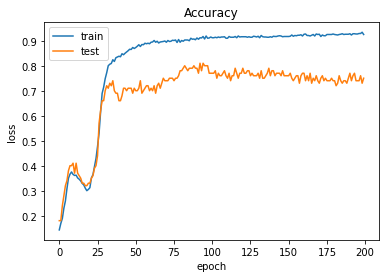

In [20]:
plt.plot (train_accuracies,  label='train')
plt.plot (test_accuracies, label='test')
plt.legend()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Accuracy')
#plt.savefig('accuracy.eps')